# FS+BAO DR1 examples

**This notebook is a basic example to perform a dr1 fs+bao cosmological inference**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

**Data path**

In [3]:
dr1_data =  {
    0: {
        'data_fn':'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.5/unblinded/desipipe/forfit_2pt/forfit_power+bao-recon_syst-rotation-hod-photo_klim_0-0.02-0.20_2-0.02-0.20_LRG_GCcomb_z0.4-0.6.npy'
    }}

**Cosmology**

In [4]:
from desilike.theories import Cosmoprimo

cosmo = Cosmoprimo(engine='class') #or camb
print(cosmo.all_params) #print cosmo params

ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'tau_reio', 'm_ncdm', 'N_eff', 'w0_fld', 'wa_fld', 'Omega_k'])


In [5]:
#You can add derived params to the cosmology as follows:

cosmo.init.params['H0'] = dict(derived=True)
cosmo.init.params['Omega_m'] = dict(derived=True)
cosmo.init.params['sigma8_m'] = dict(derived=True)
#this should be now on our cosmo params:
print(cosmo.all_params)

ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'tau_reio', 'm_ncdm', 'N_eff', 'w0_fld', 'wa_fld', 'Omega_k', 'H0', 'Omega_m', 'sigma8_m'])


In [6]:
#Lets add an ns10 and BBN prior to our cosmology

cosmo.params['n_s'].update(fixed = False)
cosmo.params['n_s'].update(prior={'dist': 'norm', 'loc': 0.9649, 'scale': 0.042})
cosmo.params['omega_b'].update(prior={'dist': 'norm', 'loc': 0.02218, 'scale': 0.00055})

print(cosmo.params['omega_b'].prior)

#and fix, for example, tau reio:
cosmo.params['tau_reio'].update(fixed = True)

norm({'loc': 0.02218, 'scale': 0.00055})


**Theory part**

In [7]:
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, DirectPowerSpectrumTemplate 
#Lets set our eft code:

#Create a template object, i.e. the parameterization of the power spectrum in terms of
#base cosmological parameters (can be switched to shapefit)
template = DirectPowerSpectrumTemplate(cosmo = cosmo, z=0.510) #this cosmo object is the cosmology we defined above, BGS-like redshift

#Create the theory object, i.e. our eft code to compare to the data:
theory = FOLPSTracerPowerSpectrumMultipoles(template=template, prior_basis = 'physical') #Add the prior_basis='physical' argument to use physically motivated priors

In [8]:
#Lets add priors on our bias and stochastic params:
theory.params['b1p'].update(prior = {'dist':'uniform','limits': [0, 3]})
theory.params['b2p'].update(prior = {'dist':'norm','loc': 0, 'scale': 5 })
theory.params['bsp'].update(prior = {'dist': 'norm', 'loc': 0, 'scale': 5})
theory.params['alpha0p'].update(prior={'dist': 'norm', 'loc': 0, 'scale': 12.5})
theory.params['alpha2p'].update(prior={'dist': 'norm', 'loc': 0, 'scale': 12.5})
theory.params['alpha4p'].update(prior={'dist': 'norm', 'loc': 0, 'scale': 12.5})
theory.params['sn0p'].update(prior={'dist': 'norm', 'loc': 0, 'scale': 2})
theory.params['sn2p'].update(prior={'dist': 'norm', 'loc': 0, 'scale': 5})

#Lets see what priors do we have for our eft code:
for param in theory.varied_params:
    print(param,theory.varied_params[param].prior)

N = 128 sampling points
M matrices have been computed
N = 128 sampling points
M matrices have been computed
h uniform[0.1, 10.0]({})
omega_cdm uniform[0.01, 0.99]({})
omega_b norm({'loc': 0.02218, 'scale': 0.00055})
logA uniform[1.61, 3.91]({})
n_s norm({'loc': 0.9649, 'scale': 0.042})
b1p uniform[0, 3]({})
b2p norm({'loc': 0.0, 'scale': 5.0})
bsp norm({'loc': 0.0, 'scale': 5.0})
alpha0p norm({'loc': 0.0, 'scale': 12.5})
alpha2p norm({'loc': 0.0, 'scale': 12.5})
alpha4p norm({'loc': 0.0, 'scale': 12.5})
sn0p norm({'loc': 0.0, 'scale': 2.0})
sn2p norm({'loc': 0.0, 'scale': 5.0})


**Reading the data**

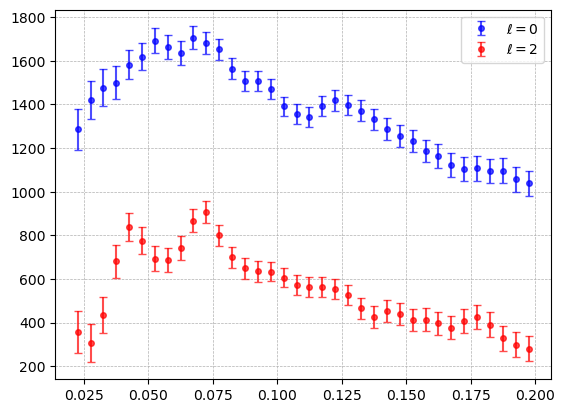

In [9]:
from desilike.observables import ObservableCovariance
#See https://desi.lbl.gov/trac/wiki/keyprojects/y1kp3/clusteringproducts#a101:Iwanttowritemychi2 
#Load and process covariance
forfit = ObservableCovariance.load(dr1_data[0]['data_fn'])
covariance = forfit.view('power') #FS-only covariance
data = forfit.observables('power') #Power spectrum measurements
ks=data.flatx #Wavenumbers
errors = np.sqrt(np.diag(covariance)) #Error bars
mono=data.view()[:36] #Monopole measurements
quad=data.view()[36:] #Quadrupole measurements

#plot the power spectrum measurements:
plt.errorbar(ks[:36], ks[:36]*mono[:36], yerr=ks[:36]*errors[:36], fmt='o', label=r'$\ell=0$'
             , capsize=3, markersize=4, color = 'b', alpha=0.7)
plt.errorbar(ks[:36], ks[:36]*quad[:36], yerr=ks[:36]*errors[:36], fmt='o', label=r'$\ell=2$'
             , capsize=3, markersize=4, color = 'r', alpha=0.7)
plt.grid(True, which='both', ls='--', lw=0.5)
plt.legend()

**Compare data vs theory**

In [10]:
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
#See https://desi.lbl.gov/trac/wiki/keyprojects/y1kp3/clusteringproducts#a101:Iwanttowritemychi2 
observable = TracerPowerSpectrumMultipolesObservable(
        #Real data:
        data=data,
        covariance = covariance,
        klim={ell: [0.02, 0.2, 0.005] for ell in [0, 2]},

        #Our eft model (contains the cosmology):
        theory=theory,
    
        #Window matrix stuff:
        wmatrix=data.attrs['wmatrix'],
        kin=data.attrs['kin'],
        ellsin=data.attrs['ellsin'],
        wshotnoise=data.attrs['wshotnoise']
    )

**Theory emulator for speed up the inference**

In [11]:
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
#Emulate the observable theory object
theory = observable.wmatrix.theory
#We only emulate the 'theory.pt' part (i.e. the cosmo params)
#because the bias params aren't computationally expensive (in general they are computed algebraically)
emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(method='finite', order=2))
emulator.set_samples()
emulator.fit()
#You can save the emulator for later use, but keep in mind all the configuration of priors and 
#cosmology are inherited to the emulator
#emulator.save('lrg1_emulator.npy')
theory.init.update(pt=emulator.to_calculator()) #Update the theory object

N = 128 sampling points
M matrices have been computed
N = 128 sampling points
M matrices have been computed


In [12]:
#Analytic marginalization over eft and nuisance parameters

#If 'physical' priors, they are called b1p, b2p, alhpa0p... 
#If not, they are just called 'b1','b2'...
params_list = ['alpha0p', 'alpha2p', 'alpha4p', 'sn0p', 'sn2p'] #We are using 'physical' priors

for param in params_list:    
    theory.params[param].update(derived = '.marg')
        
#Rename the eft and nuisance parameters to get a parameter for each tracer (i.e. QSO_alpha0, QSO_alpha2, BGS_alpha0,...)        
for param in theory.init.params:
    # Update latex just to have better labels
    param.update(namespace='{}'.format('LRG1'))

print(theory.all_params)    

ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'tau_reio', 'm_ncdm', 'N_eff', 'w0_fld', 'wa_fld', 'Omega_k', 'H0', 'Omega_m', 'sigma8_m', 'LRG1.b1p', 'LRG1.b2p', 'LRG1.bsp', 'LRG1.b3p', 'LRG1.alpha0p', 'LRG1.alpha2p', 'LRG1.alpha4p', 'LRG1.ctp', 'LRG1.sn0p', 'LRG1.sn2p'])


**BAO part**

In [13]:
from desilike.observables.galaxy_clustering import BAOCompressionObservable
flatdatas=[]

#Create and return the observable
forfit = ObservableCovariance.load(dr1_data[0]['data_fn'])
covariance, data = forfit.view(observables='bao-recon'), forfit.observables(observables='bao-recon')   
bao_observable = BAOCompressionObservable(data=data.view(), covariance=covariance, cosmo=cosmo, quantities=data.projs, z=data.attrs['zeff'])
flatdata = observable.flatdata
flatdatas.append(flatdata)

In [14]:
#Emulate the bao observable
emulator = Emulator(bao_observable, engine=TaylorEmulatorEngine(method='finite', order=2))
emulator.set_samples()
emulator.fit()
#emulator.save(emulator_filename)
bao_observable = emulator.to_calculator()

**Likelihood**

In [15]:
from desilike import setup_logging
setup_logging()
from desilike.likelihoods import ObservablesGaussianLikelihood
forfit = ObservableCovariance.load(dr1_data[0]['data_fn'])
covariance = forfit.view() #This is the FS+BAO covariance, including crosscov. terms!
likelihood = ObservablesGaussianLikelihood(observables = [observable,bao_observable], covariance = covariance)
likelihood() #initialize

[000000.00] [0/1] 10-14 08:08  ObservableCovariance      INFO     Loading /global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v1.5/unblinded/desipipe/forfit_2pt/forfit_power+bao-recon_syst-rotation-hod-photo_klim_0-0.02-0.20_2-0.02-0.20_LRG_GCcomb_z0.4-0.6.npy.


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/desilike/main/lib/python3.10/site-packages/desilike/base.py:445: UserWarning: Derived parameter H0 of <desilike.theories.galaxy_clustering.full_shape.FOLPSPowerSpectrumMultipoles object at 0x7f3fb84c7160> is already derived in <desilike.observables.galaxy_clustering.compression.BAOCompressionObservable object at 0x7f3fb85b23e0>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/desilike/main/lib/python3.10/site-packages/desilike/base.py:445: UserWarning: Derived parameter Omega_m of <desilike.theories.galaxy_clustering.full_shape.FOLPSPowerSpectrumMultipoles object at 0x7f3fb84c7160> is already derived in <desilike.observables.galaxy_clustering.compression.BAOCompressionObservable object at 0x7f3fb85b23e0>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/global/common/software/desi/users/adematti/perlmutter/co

Array(-69.75508224, dtype=float64)

**Inference**

In [16]:
from desilike.samplers import EmceeSampler, MCMCSampler
#We use the MCMC sampler included in desilike:
sampler = MCMCSampler(likelihood,save_fn = '_tests/lrg1_chain.npy')
sampler.run(check={'max_eigen_gr': 0.3})

[000002.23] [0/1] 10-14 08:08  MCMCSampler               INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'LRG1.b1p', 'LRG1.b2p', 'LRG1.bsp'].
[000003.13] [0/1] 10-14 08:08  BasePipeline              INFO     Found speeds:
[000003.13] [0/1] 10-14 08:08  BasePipeline              INFO     - <desilike.observables.galaxy_clustering.compression.BAOCompressionObservable object at 0x7f3fb85b23e0>: 193.30 iterations / second - 0.005 s / iteration
[000003.13] [0/1] 10-14 08:08  BasePipeline              INFO     - <desilike.theories.galaxy_clustering.full_shape.FOLPSPowerSpectrumMultipoles object at 0x7f3fb84c7160>: 58.81 iterations / second - 0.017 s / iteration
[000003.13] [0/1] 10-14 08:08  BasePipeline              INFO     - <desilike.theories.galaxy_clustering.full_shape.FOLPSTracerPowerSpectrumMultipoles object at 0x7f3fd82149d0>: 304.64 iterations / second - 0.003 s / iteration
[000003.13] [0/1] 10-14 08:08  BasePipeline              INFO     - <desilike.observa

[Chain(shape=(6000,), params=ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'LRG1.b1p', 'LRG1.b2p', 'LRG1.bsp', 'fweight', 'logposterior', 'tau_reio', 'm_ncdm', 'N_eff', 'w0_fld', 'wa_fld', 'Omega_k', 'LRG1.b3p', 'LRG1.ctp', 'H0', 'Omega_m', 'sigma8_m', 'loglikelihood', 'logprior', 'LRG1.alpha0p', 'LRG1.alpha2p', 'LRG1.alpha4p', 'LRG1.sn0p', 'LRG1.sn2p']))]

**Plotting**

[000599.48] [0/1] 10-14 08:18  Chain                     INFO     Loading _tests/lrg1_chain.npy.
Removed no burn in


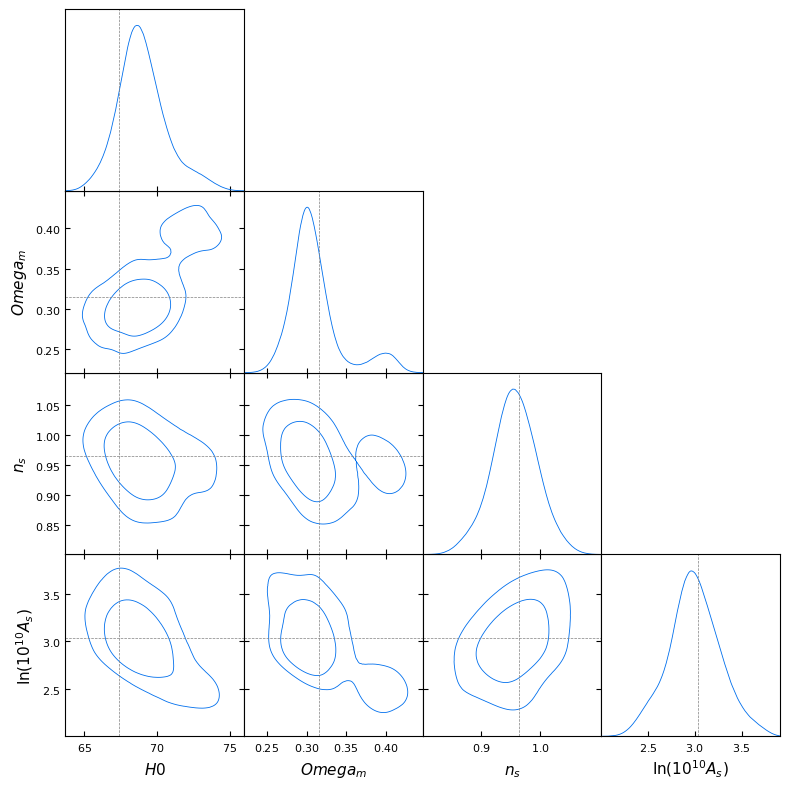

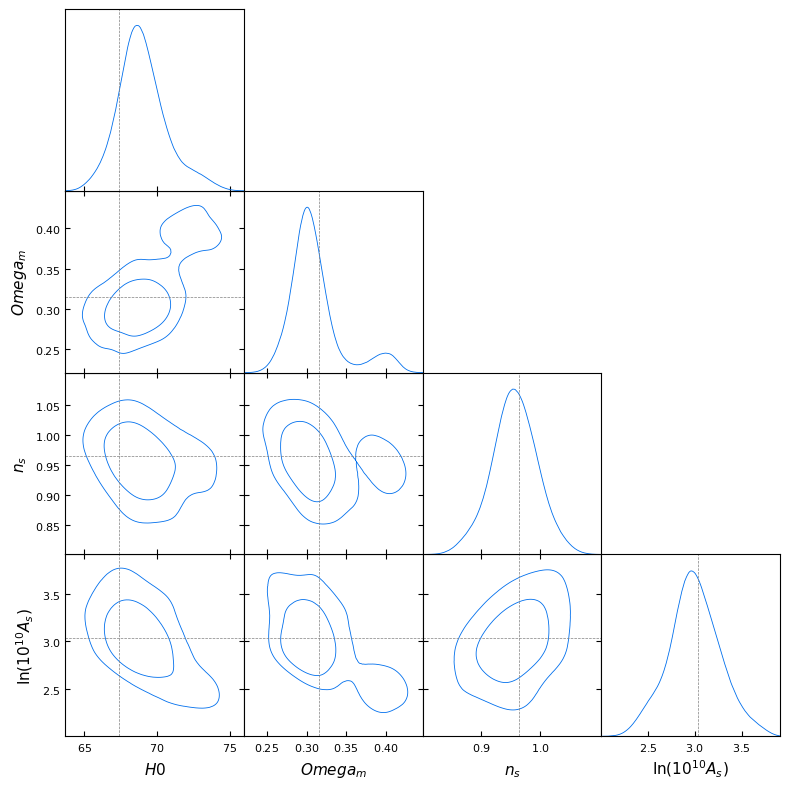

In [19]:
%matplotlib inline
from desilike.samples import plotting
from desilike.samples import Chain

chain = Chain.load('_tests/lrg1_chain.npy').remove_burnin(0.3)
plotting.plot_triangle(chain, params=['H0','Omega_m','n_s','logA'], filled = False,
                       markers=[cosmo['H0'], cosmo['Omega_m'],cosmo['n_s'],cosmo['logA']])

In [18]:
#Lets print a few stats:
print(chain.to_stats(params=['H0','Omega_m','n_s','logA'], tablefmt='pretty'))

+---------+--------+-------+--------+-------+-----------------+-----------------+
|         | argmax | mean  | median |  std  | quantile:1sigma | interval:1sigma |
+---------+--------+-------+--------+-------+-----------------+-----------------+
|   H0    |  68.0  | 69.0  |  68.8  |  1.7  |    -1.5/+1.6    |    -1.8/+1.2    |
| Omega_m | 0.305  | 0.311 | 0.304  | 0.034 |  -0.027/+0.021  |  -0.031/+0.014  |
|   n_s   | 0.943  | 0.957 | 0.956  | 0.039 |  -0.036/+0.038  |  -0.036/+0.038  |
|  logA   |  2.93  | 3.00  |  2.99  | 0.28  |   -0.25/+0.28   |   -0.26/+0.26   |
+---------+--------+-------+--------+-------+-----------------+-----------------+
